## 2: Segmentation of Biomedical Images


In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from time import time
import glob
import imageio.v2 as imageio

np.random.seed(0)

### Plotting and training functions

In [2]:
def training_curve_plot(title, train_losses, test_losses, train_accuracy, test_accuracy):
    """ 
    convenience function for plotting train and test loss and accuracy
    """
    lg=13
    md=8
    sm=7
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(title, fontsize=md)
    x = range(1, len(train_losses)+1)
    axs[0].plot(x, train_losses, label=f'Final train loss: {train_losses[-1]:.4f}')
    axs[0].plot(x, test_losses, label=f'Final test loss: {test_losses[-1]:.4f}')
    axs[0].set_title('Losses', fontsize=md)
    axs[0].set_xlabel('Iteration', fontsize=md)
    axs[0].set_ylabel('Loss', fontsize=md)
    axs[0].legend(fontsize=sm)
    axs[0].tick_params(axis='both', labelsize=sm)
    # Optionally use a logarithmic y-scale
    #axs[0].set_yscale('log')
    axs[0].grid(True, which="both", linestyle='--', linewidth=0.5)
    axs[1].plot(x, train_accuracy, label=f'Final train dice: {train_accuracy[-1]:.4f}%')
    axs[1].plot(x, test_accuracy, label=f'Final test dice: {test_accuracy[-1]:.4f}%')
    axs[1].set_title('dice', fontsize=md)
    axs[1].set_xlabel('Iteration', fontsize=md)
    axs[1].set_ylabel('dice (%)', fontsize=sm)
    axs[1].legend(fontsize=sm)
    axs[1].tick_params(axis='both', labelsize=sm)
    axs[1].grid(True, which="both", linestyle='--', linewidth=0.5)
    plt.show()

In [21]:
def plot_image(title: str, input_im: torch.Tensor, model_mask: torch.Tensor, label_mask: torch.Tensor, dice_score: float):
    """
    Plots 3 images side by side, 
    highlighting difference between 
    ground truth and model output
    Args:
        title: str, title of the plot
        input_im: torch.Tensor, input image
        model_mask: torch.Tensor, model output
        label_mask: torch.Tensor, ground truth
        dice_score: float, dice score
    """
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    fig.suptitle(title, fontsize=15)
    axs[0].imshow(input_im[0, 0].cpu().numpy(), cmap='gray')
    axs[0].set_title('Input Image')
    axs[1].imshow(model_mask[0, 0].cpu().numpy(), cmap='gray')
    axs[1].set_title('Model Mask')
    axs[2].imshow(label_mask[0, 0].cpu().numpy(), cmap='gray')
    axs[2].set_title('True Mask')
    plt.show() 

In [3]:
def dice_coefficient(outputs, targets):
    eps = 1e-8
    intersection = torch.sum(abs(outputs) * abs(targets))
    union = torch.sum(outputs) + torch.sum(targets)
    dice = (2. * intersection) / abs(union + eps)
    return dice

def train_network(model: nn.Module, criteria: nn.Module, 
                  optimizer: torch.optim.Optimizer, num_epochs: int, train_loader: torch.utils.data.DataLoader, 
                  test_loader: torch.utils.data.DataLoader, device: torch.device, model_name: str, lr: float) -> None:
    """
    Train a neural network model
    
    Args:
        model: The neural network model to be trained
        criteria: The loss function
        optimizer: The optimizer
        num_epochs: The number of epochs to train the model
        train_loader: The training data loader
        test_loader: The test data loader
        device: The device to run the model on
    """
    train_losses = []
    test_losses = []
    train_dice_scores = []
    test_dice_scores = []
    start = time()
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_dice = 0

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criteria(outputs, labels)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

            # Calculate Dice score
            outputs = (outputs > 0.5).float()
            dice = dice_coefficient(outputs, labels)
            train_dice += dice.item()
        
        train_losses.append(train_loss / len(train_loader))
        train_dice_scores.append(train_dice / len(train_loader))
    
        model.eval()
        test_loss = 0
        test_dice = 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criteria(outputs, labels)
                test_loss += loss.item()

                # Calculate Dice score
                outputs = (outputs > 0.5).float()
                dice = dice_coefficient(outputs, labels)
                test_dice += dice.item()
            
            test_losses.append(test_loss / len(test_loader))
            test_dice_scores.append(test_dice / len(test_loader))
        if (epoch+1)%10 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Train Dice Score: {train_dice_scores[-1]:.4f}, Test Dice Score: {test_dice_scores[-1]:.4f}')
    total = time() - start
    plot_title = model_name + " - lr: " + str(lr) + " - Total Time: " + str(total // 60) + "min " + str(total % 60) + "s " + "-Epochs: " + str(num_epochs)
    return plot_title, train_losses, test_losses, train_dice_scores, test_dice_scores

### Loading of Warwick dataset

In [4]:

def load_warwick():

  train_images = []
  train_labels = []
  test_images = []
  test_labels = []

  for image_path in sorted(glob.glob("WARWICK/WARWICK" + "/Train/image_*.png")):
    image = imageio.imread(image_path)
    train_images.append(image)
  for label_path in sorted(glob.glob("WARWICK/WARWICK" + "/Train/label_*.png")):
    label = imageio.imread(label_path)
    train_labels.append(label)  

  for image_path in sorted(glob.glob("WARWICK/WARWICK" + "/Test/image_*.png")):
    image = imageio.imread(image_path)
    test_images.append(image)
  for label_path in sorted(glob.glob("WARWICK/WARWICK" + "/Test/label_*.png")):
    label = imageio.imread(label_path)
    test_labels.append(label)

  X_train = torch.tensor(np.array(train_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_train = torch.tensor(np.array(train_labels), dtype=torch.long)/255
  X_test = torch.tensor(np.array(test_images), dtype=torch.float, requires_grad=True).permute(0,3,1,2)
  Y_test = torch.tensor(np.array(test_labels), dtype=torch.long)/255

  return X_train, Y_train, X_test, Y_test
     


In [5]:
bz = 16
X_train, Y_train, X_test, Y_test = load_warwick()
# create dataloader
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=bz, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=bz, shuffle=False)

In [6]:
# look at the size of image and label
print(X_train.size())
print(Y_train.size())


torch.Size([85, 3, 128, 128])
torch.Size([85, 128, 128])


### Models (i = CNN from last exercise, ii = variant of Unet (no residual connections))

In [7]:
class convnetrefurbed(nn.Module):
    def __init__(self):
        super(convnetrefurbed, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(8, 16, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.relu3 = nn.ReLU()

        self.up1 = nn.ConvTranspose2d(32, 16, 2, 2)
        self.relu4 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(16, 1, 3, 1, 1)
        self.up2 = nn.ConvTranspose2d(1, 1, 2, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.relu3(x)

        x = self.up1(x)
        x = self.relu4(x)

        x = self.conv4(x)
        x = self.up2(x)
        return x.squeeze()

        

In [8]:


# Define the modified CNN architecture
class UNet_Variant(nn.Module):
    def __init__(self):
        super(UNet_Variant, self).__init__()
        # Initialize the layers for 3x128x128 input
        self.conv1 = nn.Conv2d(3, 3, 1, 1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(3, 3, 1, 1)
      
        # Max pool and downsampling
        self.pool = nn.MaxPool2d(2, 2)
        # Initialize the layers for 3x64x64 input
        self.conv3 = nn.Conv2d(3, 3, 1, 1)
        self.relu2 = nn.ReLU()
        self.conv4 = nn.Conv2d(3, 3, 1, 1)
        
        # Max pool and downsampling
        self.pool1 = nn.MaxPool2d(2, 2)
        # Initialize the layers for 3x32x32 input
        self.conv5 = nn.Conv2d(3, 3, 1, 1)
        self.relu3 = nn.ReLU()
        self.conv6 = nn.Conv2d(3, 3, 1, 1)
        # Max pool and downsampling
        self.pool2 = nn.MaxPool2d(2, 2)
        # Initialize the layers for 3x16x16 input
        self.conv7 = nn.Conv2d(3, 3, 1, 1)
        self.relu4 = nn.ReLU()
        self.conv8 = nn.Conv2d(3, 3, 1, 1)
        
        # Upsampling and deconvolution using transposed convolution
        self.up1 = nn.ConvTranspose2d(3, 3, 2, 2)
        # Initialize the layers for 3x32x32 input
        self.conv9 = nn.Conv2d(3, 3, 1, 1)
        self.relu5 = nn.ReLU()
        self.conv10 = nn.Conv2d(3, 3, 1, 1)
        # Upsampling and deconvolution using transposed convolution
        self.up2 = nn.ConvTranspose2d(3, 3, 2, 2)
        # Initialize the layers for 3x64x64 input
        self.conv11 = nn.Conv2d(3, 3, 1, 1)
        self.relu6 = nn.ReLU()
        self.conv12 = nn.Conv2d(3, 3, 1, 1)
        # Upsampling and deconvolution using transposed convolution
        self.up3 = nn.ConvTranspose2d(3, 3, 2, 2)
        # Initialize the layers for 1x128x128 input
        self.conv13 = nn.Conv2d(3, 3, 1, 1)
        self.relu7 = nn.ReLU()
        self.conv14 = nn.Conv2d(3, 1, 1, 1)

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu2(x)
        x = self.conv4(x)
        x = self.pool1(x)
        x = self.conv5(x)
        x = self.relu3(x)
        x = self.conv6(x)
        x = self.pool2(x)
        x = self.conv7(x)
        x = self.relu4(x)
        x = self.conv8(x)
        x = self.up1(x)
        x = self.conv9(x)
        x = self.relu5(x)
        x = self.conv10(x)
        x = self.up2(x)
        x = self.conv11(x)
        x = self.relu6(x)
        x = self.conv12(x)
        x = self.up3(x)
        x = self.conv13(x)
        x = self.relu7(x)
        x = self.conv14(x)

        return x.squeeze()



In [9]:
# Hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1000
learning_rate = 0.001   
criterion = nn.BCEWithLogitsLoss()
model = convnetrefurbed().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [10]:
nets = {}


In [11]:
nets["cnet"] = train_network(model, criterion, optimizer, num_epochs=num_epochs,train_loader=train_loader, test_loader=test_loader,  device=device, model_name='Modified CNN', lr=learning_rate)

Epoch 10/1000, Train Loss: 0.6516, Test Loss: 0.6697, Train Dice Score: 0.3861, Test Dice Score: 0.3185
Epoch 20/1000, Train Loss: 0.5783, Test Loss: 0.7000, Train Dice Score: 0.5410, Test Dice Score: 0.6019
Epoch 30/1000, Train Loss: 0.4840, Test Loss: 0.5481, Train Dice Score: 0.7156, Test Dice Score: 0.6537
Epoch 40/1000, Train Loss: 0.4510, Test Loss: 0.5282, Train Dice Score: 0.7742, Test Dice Score: 0.5899
Epoch 50/1000, Train Loss: 0.4271, Test Loss: 0.5119, Train Dice Score: 0.7921, Test Dice Score: 0.7475
Epoch 60/1000, Train Loss: 0.4010, Test Loss: 0.4971, Train Dice Score: 0.8095, Test Dice Score: 0.7804
Epoch 70/1000, Train Loss: 0.4374, Test Loss: 0.4912, Train Dice Score: 0.7827, Test Dice Score: 0.7617
Epoch 80/1000, Train Loss: 0.3974, Test Loss: 0.4864, Train Dice Score: 0.7971, Test Dice Score: 0.7818
Epoch 90/1000, Train Loss: 0.3913, Test Loss: 0.4537, Train Dice Score: 0.8159, Test Dice Score: 0.7371
Epoch 100/1000, Train Loss: 0.3655, Test Loss: 0.4615, Train Dic

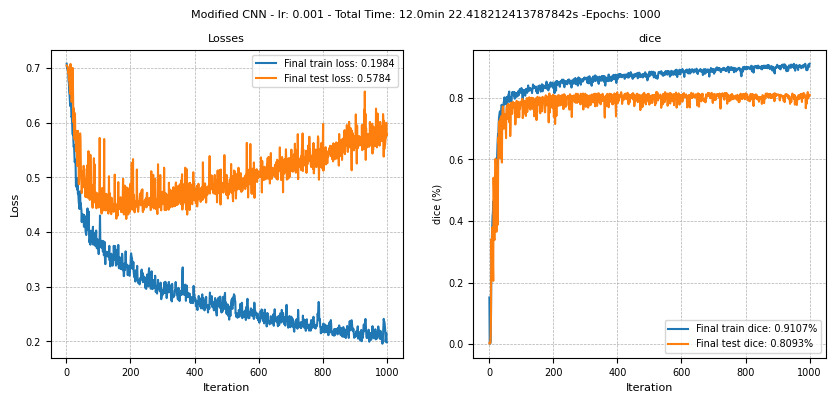

In [12]:
# Plot the loss and dice score
training_curve_plot(*nets["cnet"])

In [18]:
#initilize unet model
num_epochs = 1000
learning_rate = 0.1 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet_Variant().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()


In [19]:
nets["unet"] = train_network(model, criterion, optimizer, num_epochs=num_epochs,train_loader=train_loader, test_loader=test_loader,  device=device, model_name='UNet Variant', lr=learning_rate)

Epoch 10/1000, Train Loss: 0.6941, Test Loss: 0.6943, Train Dice Score: 0.0000, Test Dice Score: 0.0000
Epoch 20/1000, Train Loss: 0.6941, Test Loss: 0.6941, Train Dice Score: 0.0000, Test Dice Score: 0.0000
Epoch 30/1000, Train Loss: 0.6942, Test Loss: 0.6935, Train Dice Score: 0.0000, Test Dice Score: 0.0000
Epoch 40/1000, Train Loss: 0.6935, Test Loss: 0.6932, Train Dice Score: 0.0000, Test Dice Score: 0.0000
Epoch 50/1000, Train Loss: 0.6933, Test Loss: 0.6932, Train Dice Score: 0.0000, Test Dice Score: 0.0000


KeyboardInterrupt: 

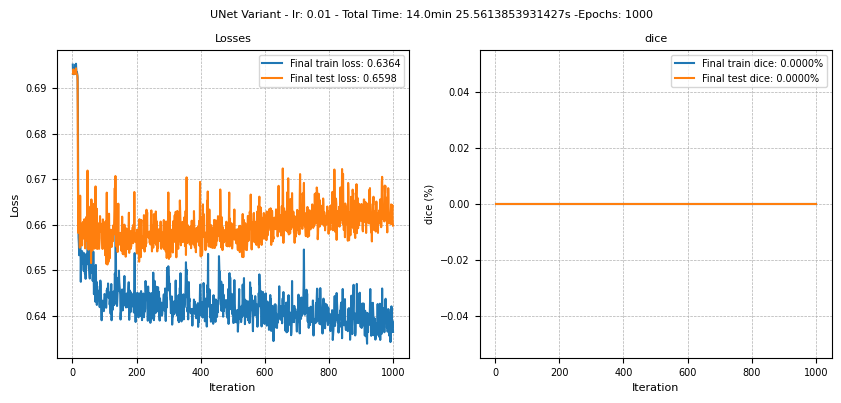

In [15]:
training_curve_plot(*nets["unet"])